In [1]:
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.gaussian_process.kernels import RBF
import scipy.stats as stats
import math
from mpl_toolkits import mplot3d
from cosde.osde import MultiOSDE

### Test univariate standard normal distribution

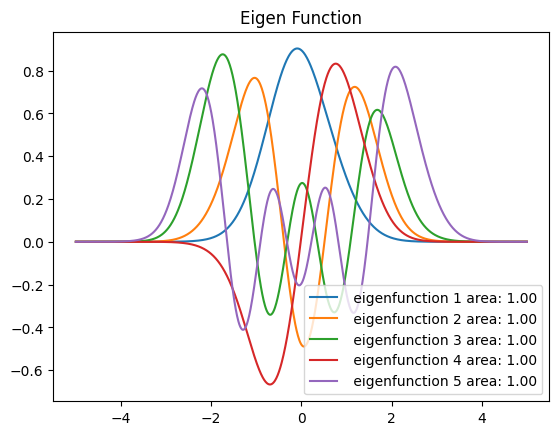

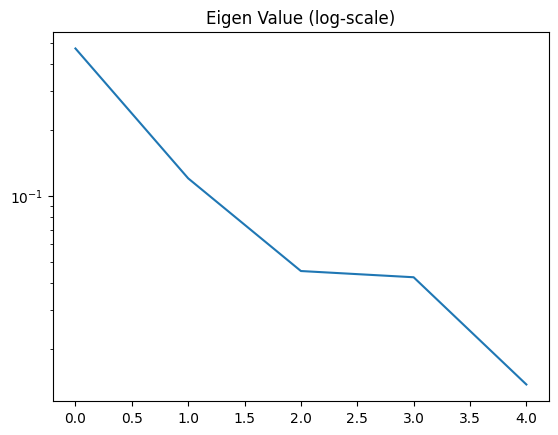

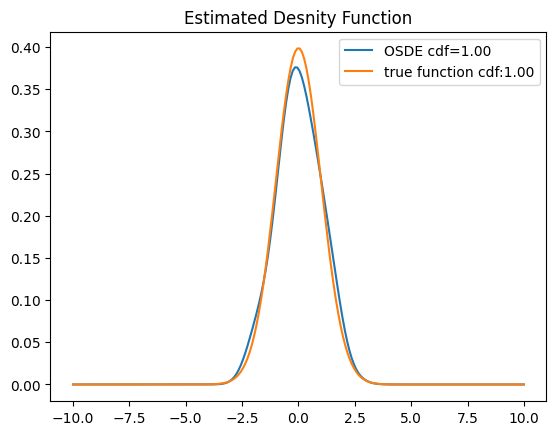

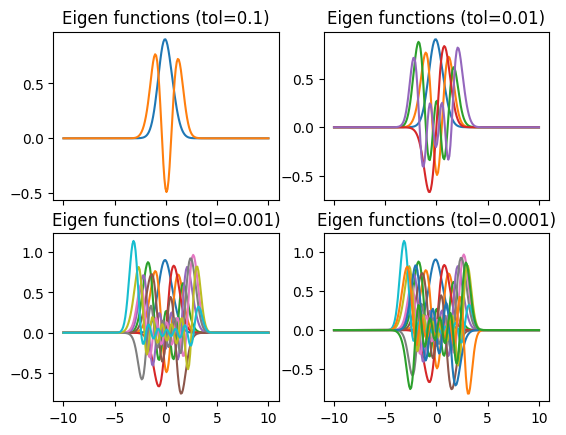

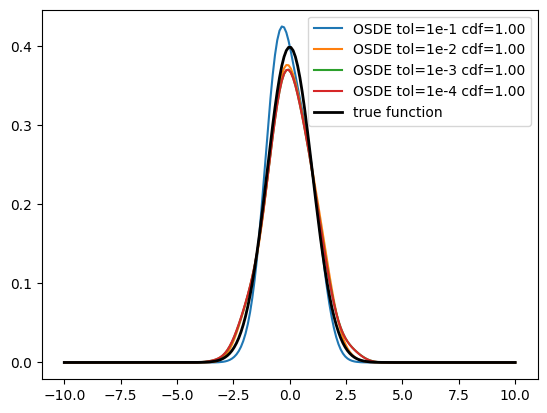

In [2]:
##test MultiOSDE

#test 1 variables
kernelx = RBF(.425)

kernel_list = [kernelx]
f_x = MultiOSDE(kernel_list)
data_x = np.random.normal(0, 1, size=(1000, 1))
data_list = [data_x]
f_x.fit(data_list, 1e-2)

for i in range(1,f_x.r+1):
  eigen = f_x.get_eigen_function(1,i)
  new_x = np.linspace(-5,5,1000)
  hf_x = np.zeros(new_x.shape)
  area=0
  x_0 = -5
  for j, x in enumerate(new_x):
    hf_x[j] = eigen.eval(x.reshape((1,1)))
    area += np.abs(hf_x[j]**2)*(x-x_0)
    x_0 = x
  plt.plot(new_x, hf_x, label=" eigenfunction %d area: %.2f"%(i,np.sqrt(area)))
plt.title('Eigen Function')
plt.legend()
plt.show()

#test get_singular_value()
sigv = []
for i in range(1,f_x.r+1):
  sigv.append(f_x.get_singular_value(i))
plt.plot(sigv)
plt.title('Eigen Value (log-scale)')
plt.yscale('log')
#test get_density_function()
#test get_pdf()
plt.show()



new_x = np.linspace(-10,10,200)
cdf = 0
predict_x = np.zeros(new_x.shape)
d0 = new_x[0]
for i, d in enumerate(new_x):
  predict_x[i] = f_x.get_pdf([d.reshape((1,1))])
  cdf += predict_x[i]*(d-d0)
  d0 = d
plt.title('Estimated Desnity Function')
plt.plot(new_x,predict_x, label='OSDE cdf=%.2f'%cdf)   
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 200)
cdf = np.sum(stats.norm.pdf(x, mu, sigma))*(20*sigma/200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='true function cdf:%.2f'%cdf)

plt.legend()
plt.show()

f, ax = plt.subplots(2, 2, sharex=True)
predict_list = []
cdf_list = []
tol_list = [1e-1,1e-2,1e-3,1e-4]
for i, tol in enumerate(tol_list):
  f_x = MultiOSDE(kernel_list)
  f_x.fit(data_list, tol)
  for j in range(1,f_x.r+1):
    eigen = f_x.get_eigen_function(1,j)
    hf_x = np.zeros(new_x.shape)
    for j, x in enumerate(new_x):
      hf_x[j] = eigen.eval(x.reshape((1,1)))
    ax[i//2,i%2].plot(new_x, hf_x)
    ax[i//2,i%2].title.set_text('Eigen functions (tol={})'.format(tol))

  pf = np.zeros(new_x.shape)
  cdf = 0

  x0 = new_x[0]
  for j,x in enumerate(new_x):
    pf[j] = f_x.get_pdf([x.reshape((1,1))])
    cdf += pf[j]*(x-x0)
    x0 = x
  predict_list.append(pf)
  cdf_list.append(cdf)
plt.show()
for cdf, label, pf in zip(cdf_list, tol_list, predict_list):
  plt.plot(new_x, pf, label='OSDE tol=1e%d cdf=%.2f'%(np.log10(label), cdf))

variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='k', linewidth=2, label='true function')

plt.legend()
plt.show()


### test univariate mixture model

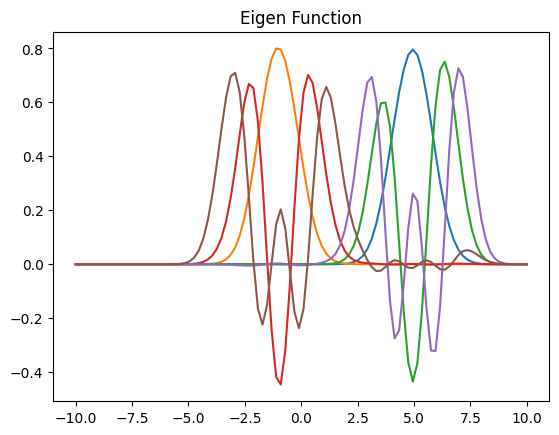

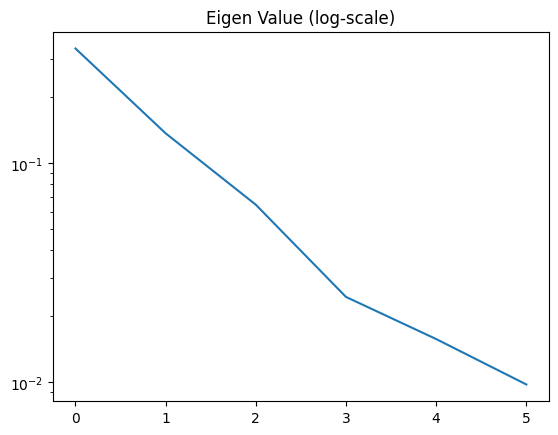

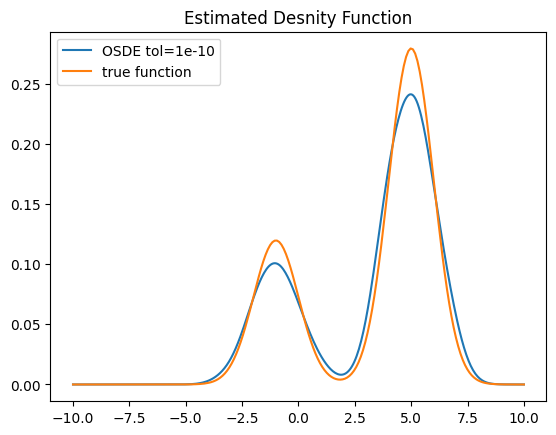

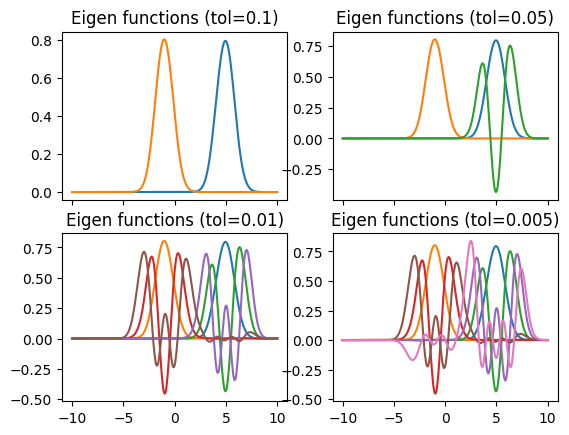

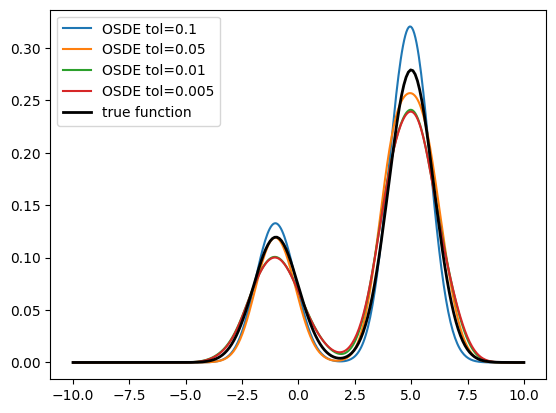

In [3]:
##test MultiOSDE
def gaussian_mixture(N):
  #[0.1,0.2,0.7]
  U = np.random.uniform(0,1,N)
  X = np.random.normal(-1,1, size=(N,1))
  #idx_0 = np.where(U<0.3)
  idx_1 = np.where(U>=0.3)
  X[idx_1[0],0] += 6 #shift in mean
  return X
#test 1 variables
kernelx = RBF(.55)

kernel_list = [kernelx]
f_xyz = MultiOSDE(kernel_list)


data_x = gaussian_mixture(1000)

data_list = [data_x]
f_xyz.fit(data_list, 1e-2)

for i in range(1,f_xyz.r+1):
  eigen = f_xyz.get_eigen_function(1,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))
  plt.plot(new_x, f_x)
plt.title('Eigen Function')
plt.show()

#test get_singular_value()
sigv = []
for i in range(1,f_xyz.r+1):
  sigv.append(f_xyz.get_singular_value(i))
plt.plot(sigv)
plt.title('Eigen Value (log-scale)')
plt.yscale('log')
#test get_density_function()
#test get_pdf()
plt.show()
new_x = np.linspace(-10,10,400)
predict_x = np.zeros(new_x.shape)
for i, d in enumerate(new_x):
  predict_x[i] = f_xyz.get_pdf([d.reshape((1,1))])
plt.title('Estimated Desnity Function')
plt.plot(new_x,predict_x, label='OSDE tol=1e-10')   
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 200)
plt.plot(x, 0.3*stats.norm.pdf(x, mu-1, sigma)+0.7*stats.norm.pdf(x, 5, sigma), label='true function')

plt.legend()
plt.show()

f, ax = plt.subplots(2, 2, sharex=True)
predict_list = []
tol_list = [1e-1, 5*1e-2,1e-2,5*1e-3]
for i, tol in enumerate(tol_list):
  f_xyz = MultiOSDE(kernel_list)
  f_xyz.fit(data_list, tol)
  for j in range(1,f_xyz.r+1):
    eigen = f_xyz.get_eigen_function(1,j)
    f_x = np.zeros(new_x.shape)
    for j, x in enumerate(new_x):
      f_x[j] = eigen.eval(x.reshape((1,1)))
    ax[i//2,i%2].plot(new_x, f_x)
    ax[i//2,i%2].title.set_text('Eigen functions (tol={})'.format(tol))

  pf = np.zeros(new_x.shape)
  for j,x in enumerate(new_x):
    pf[j] = f_xyz.get_pdf([x.reshape((1,1))])
  predict_list.append(pf)
plt.show()
for label, pf in zip(tol_list, predict_list):
  plt.plot(new_x, pf, label='OSDE tol={}'.format(label))

variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 200)
plt.plot(x, 0.3*stats.norm.pdf(x, mu-1, sigma)+0.7*stats.norm.pdf(x, 5, sigma), color='k', linewidth=2, label='true function')

plt.legend()
plt.show()


### test bivariate standard normal

flip functions:  0


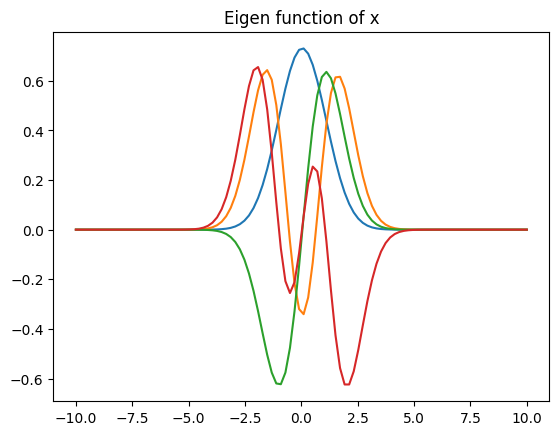

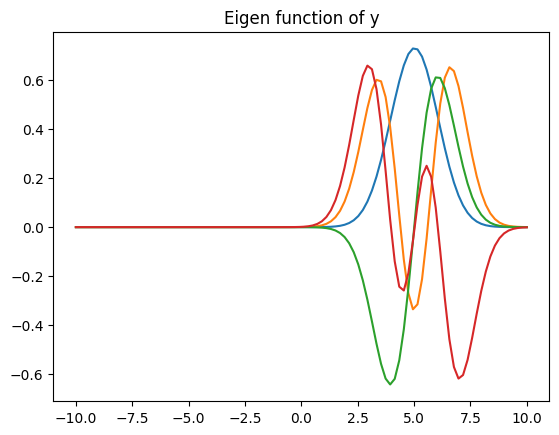

area:0.26 cmf:0.98


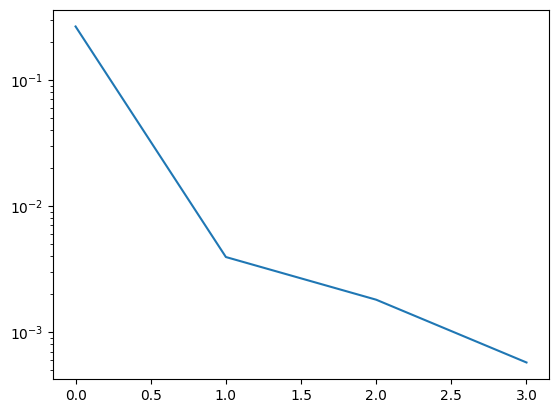

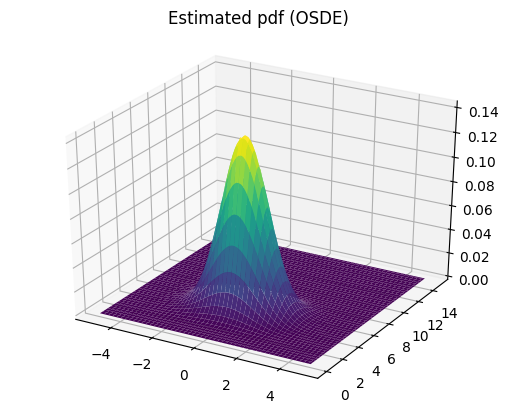

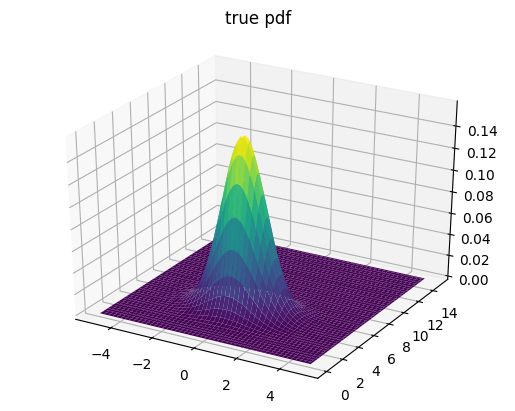

In [4]:
##test MultiOSDE

#test 2 variables
kernelx = RBF(.75)
kernely = RBF(.75)
kernel_list = [kernelx, kernely]
f_xy = MultiOSDE(kernel_list)
data_x = np.random.normal(0, 1, size=(2000, 1))
data_y = np.random.normal(5, 1, size=(2000, 1))


data_list = [data_x, data_y]
f_xy.fit(data_list, 1e-3)

for i in range(1,f_xy.r+1):
  eigen = f_xy.get_eigen_function(1,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))

  plt.plot(new_x, f_x)

plt.title('Eigen function of x')
plt.show()
#test get_eigen_function()
for i in range(1,f_xy.r+1):
  eigen = f_xy.get_eigen_function(2,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))
  plt.plot(new_x, f_x)
plt.title('Eigen function of y')
plt.show()

#test get_singular_value()
sigv = []
for i in range(1,f_xy.r+1):
  sigv.append(f_xy.get_singular_value(i))
plt.plot(sigv)
plt.yscale('log')
#test get_density_function()
#test get_pdf()

new_x = np.linspace(-5,5,100)
new_y = np.linspace(0,15,100)

grid = np.meshgrid(new_x,new_y)
data_x = grid[0].flatten()
data_y = grid[1].flatten()
pf = np.zeros(data_x.shape[0])
i=0
area = 0
cmf = 0
for x,y in zip(data_x, data_y):
  sample = [x.reshape(1,1), y.reshape(1,1)]
  pf[i] = f_xy.get_pdf(sample)
  area += pf[i]**2
  cmf += np.abs(pf[i])
  i+=1
area *= (15/100)*(10/100)
cmf *= (15/100)*(10/100)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], pf.reshape(100,100),
                cmap='viridis',linewidth=0, label='area:%.2f'%np.sqrt(area))


ax.title.set_text('Estimated pdf (OSDE)')
print('area:%.2f cmf:%.2f'%(np.sqrt(area), cmf))

#Parameters to set
mu_x = 0
variance_x = 1

mu_y = 5
variance_y = 1

#Create grid and multivariate normal

pos = np.empty(grid[0].shape + (2,))
pos[:, :, 0] =  grid[0]
pos[:, :, 1] =  grid[1]
rv = stats.multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1], rv.pdf(pos),cmap='viridis',linewidth=0)



ax.title.set_text('true pdf')




plt.show()

### test bivariate mixture Gaussian

flip functions:  0


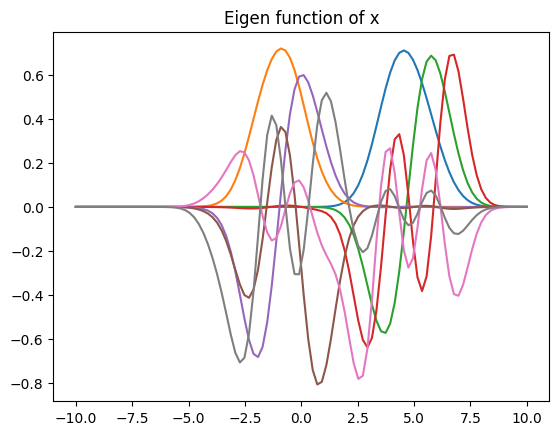

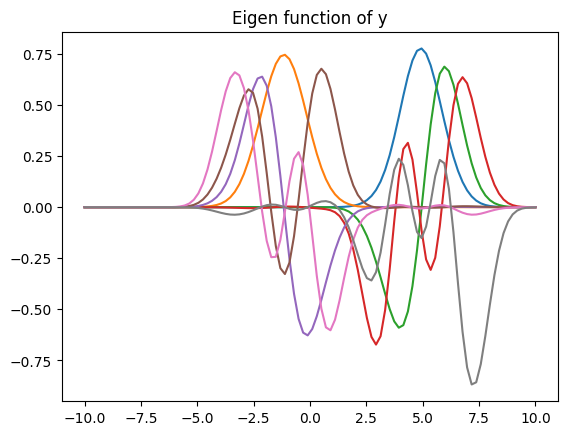

area:0.23 cmf:1.00


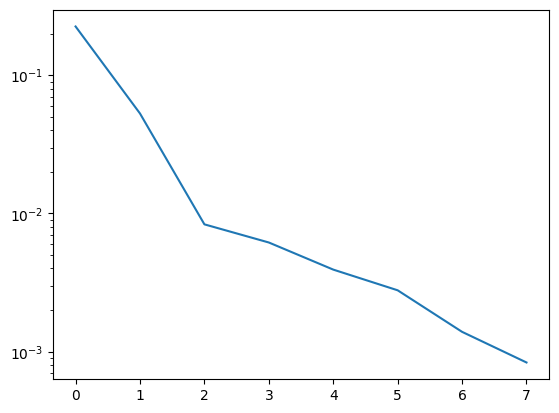

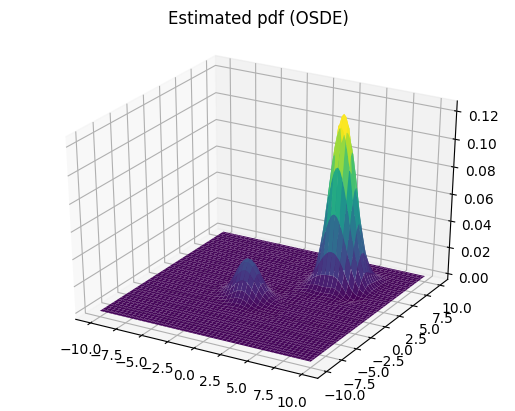

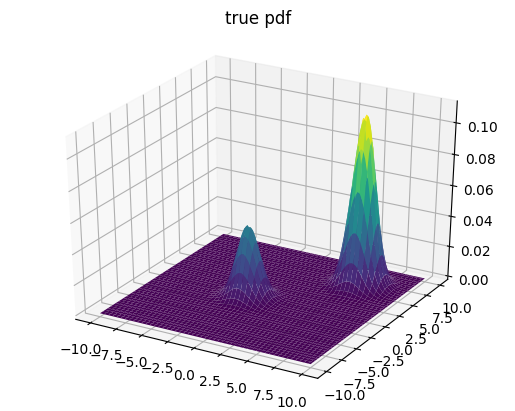

In [6]:
##test MultiOSDE

#test 2 variables
kernelx = RBF(.7)
kernely = RBF(.7)
kernel_list = [kernelx, kernely]
f_xy = MultiOSDE(kernel_list)

def gaussian_mixture(N):
  #[0.1,0.2,0.7]
  U = np.random.uniform(0,1,N)
  X = np.random.normal(-1,1, size=(N,1))
  #idx_0 = np.where(U<0.4)
  idx_1 = np.where(U>=0.3)
  X[idx_1[0],0] += 6 #shift in mean
  return X

data_x = gaussian_mixture(1000)
data_y = gaussian_mixture(1000)


data_list = [data_x, data_y]
f_xy.fit(data_list, 1e-3)

for i in range(1,f_xy.r+1):
  eigen = f_xy.get_eigen_function(1,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))

  plt.plot(new_x, f_x)

plt.title('Eigen function of x')
plt.show()
#test get_eigen_function()
for i in range(1,f_xy.r+1):
  eigen = f_xy.get_eigen_function(2,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))
  plt.plot(new_x, f_x)
plt.title('Eigen function of y')
plt.show()

#test get_singular_value()
sigv = []
for i in range(1,f_xy.r+1):
  sigv.append(f_xy.get_singular_value(i))
plt.plot(sigv)
plt.yscale('log')
#test get_density_function()
#test get_pdf()

new_x = np.linspace(-10,10,100)
new_y = np.linspace(-10,10,100)

grid = np.meshgrid(new_x,new_y)
data_x = grid[0].flatten()
data_y = grid[1].flatten()
pf = np.zeros(data_x.shape[0])
i=0
area = 0
cmf = 0
for x,y in zip(data_x, data_y):
  sample = [x.reshape(1,1), y.reshape(1,1)]
  pf[i] = f_xy.get_pdf(sample)
  area += pf[i]**2
  cmf += np.abs(pf[i])
  i+=1
area *= (0.2)**2
cmf *= (0.2)**2
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], pf.reshape(100,100)/cmf,
                cmap='viridis',linewidth=0, label='area:%.2f'%np.sqrt(area))


ax.title.set_text('Estimated pdf (OSDE)')
print('area:%.2f cmf:%.2f'%(np.sqrt(area), cmf))
#Parameters to set
mu_x = -1
variance_x = 1

mu_y = -1
variance_y = 1

#Create grid and multivariate normal

pos = np.empty(grid[0].shape + (2,))
pos[:, :, 0] =  grid[0]
pos[:, :, 1] =  grid[1]
rv = stats.multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])


rv2 = stats.multivariate_normal([6, 6], [[variance_x, 0], [0, variance_y]])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1], 0.3*rv.pdf(pos)+0.7*rv2.pdf(pos),cmap='viridis',linewidth=0)



ax.title.set_text('true pdf')




plt.show()